# 1. Introduction to the MNIST data

For this classification project, we will be using the MNIST data set that contain 70,000 images of handwritten digits. In this data set, each row represents an image and each column a pixel from a 28 by 28 pixel image. The MNIST dataset is widely used to train classifiers and can be fetched using the helper function sklearn.datasets.fetch_openml.

The code below will download the data, and sample 20,000 rows from the original dataset. I will be reducing the number of rows in the dataset to decrease model size and to reduce build time for this project. The code below will also plot the first image in the data set which we can see is the number eight.

(-0.5, 27.5, 27.5, -0.5)

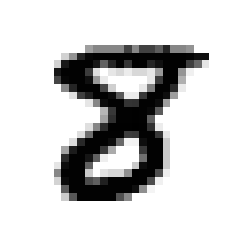

In [1]:
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import pandas as pd

# Load data
mnist = fetch_openml("mnist_784", version=1)

# Randomly sample 20000 rows from the original dataset
mnist_data = (
    mnist
    .data
    .sample(n=20000, random_state=42, axis=0, replace=False)
)

# Slice target by the same row sampling
target = (
    mnist
    .target
    .loc[mnist_data.index].astype('uint8')
)

# Reshape values to be 28x28
some_digit_image = (
    mnist_data
    .iloc[0]
    .values
    .reshape(28,28)
    .astype('float32')
)
plt.imshow(some_digit_image, cmap = "binary")
plt.axis("off")

<hr>

# 2. Training a K-Nearest Neighbors Classifier

First we will split the data into training and test set then train a K-nearest neighbour classifier using thescikit-learn library.

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import  KNeighborsClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

# Function to train KNN Classifier and show scores
def train_knn_model(features:np.array, target:np.array):

    # Train KNN Classifier
    knnclf = KNeighborsClassifier(weights='distance', n_neighbors=4)
    knnclf.fit(features, target)
    scores = cross_val_score(
        knnclf, features, target, scoring='accuracy', cv=10
    )
    print(f'Cross Validation Scores: {scores}')
    print(f'Average accuracy: {np.mean(scores)}')
    return knnclf, scores

# Split data to training and test set
train_features, test_features, train_target, test_target = train_test_split(
        mnist_data, target, test_size = 0.2, random_state = 42
)
knnclf, scores = train_knn_model(train_features, train_target)

Cross Validation Scores: [0.956875 0.96375  0.95625  0.953125 0.955    0.955    0.958125 0.95375
 0.960625 0.958125]
Average accuracy: 0.9570625000000001


The model achieves a decent average accuracy of 96% from cross validation. Let's evaluate the model's performance on the test_features data set and plot a confusion matrix with the show_cm function as shown below.

Accuracy: 0.95725


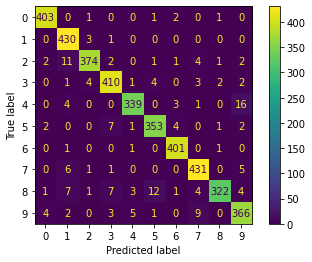

In [5]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

def show_cm(y_true, y_pred, labels):

    # Display Confusion matrix and show accuracy scores
    conf_mat = confusion_matrix(y_true, y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=labels)
    score = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {score}')
    disp.plot();

# Make predictions
test_target_pred = knnclf.predict(test_features)
# Show confusion matrix
show_cm(test_target, test_target_pred, range(10))

Base on the accuracy on the test data set, we can see that our model fits the data. We get very similar prediction accuracy when comparing accuracies between the training and testing set. 

Furthermore, a confusion matrix, like above, is very effective in helping visualise the gaps in the model's performance. It will help us understand the kind of errors that the classifier is making.

The matrix indicates that there were 16 instances where the number 4 was misidentified for the number 9, and 12 instances where the number 8 was misidentified for the number 5. 

Looking at the images below, it is possible to see why some of these errors may occur as the number 4 and 9 do share some similar features. Likewise for the number 8 and 5.

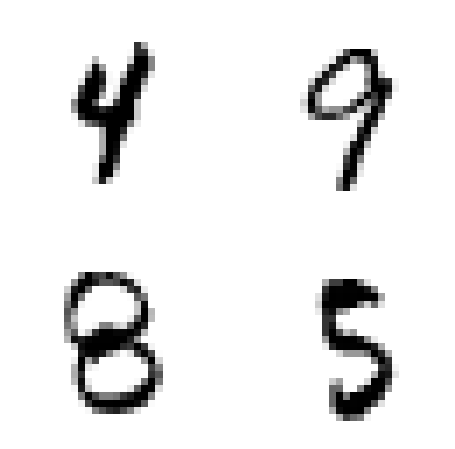

In [6]:
import matplotlib.pyplot as plt

def show_digits(pixel_vals):

    some_digit_image = (
        pixel_vals
        .values
        .reshape(28,28)
        .astype('float32')
    )
    plt.imshow(some_digit_image, cmap = "binary")
    plt.axis("off")

fours = train_features[train_target == 4]
nines = train_features[train_target == 9]
eights = train_features[train_target == 8]
fives = train_features[train_target == 5]

plt.figure(figsize=(8,8))
plt.subplot(221); show_digits(fours.iloc[0])
plt.subplot(222); show_digits(nines.iloc[0])
plt.subplot(223); show_digits(eights.iloc[1])
plt.subplot(224); show_digits(fives.iloc[1])

This insight is not going to affect model deployment on AWS but will help guide strategies to further improve the model. 
For now, we will save the model locally to be containerised as part of the lambda function using Docker.

In [7]:
import joblib

joblib.dump(knnclf, 'app/knnclf.joblib')

['app/knnclf.joblib']

<hr>

# 3. Initialising AWS S3 Bucket

The image below illustrates the overall resource infrastructure that will need to be deployed to support our lambda function. There are three key resources requirements for our application:

1. S3 Bucket to store data.
2. API gateway to manage HTTP requests.
3. Lambda function containing the predictive logic.

![](overview.png)

#### Serverless deployment of ML models

1. Test data is uploaded to a S3 bucket.

2. To initiate the lambda function, a POST HTTP request is sent through the Amazon API Gateway. 

3. Initialisation of the lambda function executes code that downloads the data from the S3 bucket and performs predictions. 

4. A HTTP response is returned to client with the predictions as a data payload.

The Lambda function will contain Python code that performs a prediction based on the test_features dataset stored on a S3 bucket. 

Therefore, we will first need to initialise a S3 bucket where we can host our data.

To do so, we will be interacting with AWS using the AWS Python SDK `boto3`. This package contains all the dependencies we require to integrate Python projects with AWS. 

Let's initialise a S3 bucket with the code below.

***Note:*** *The `bucket_name` has to be unique therefore you will have to replace the bucket_name with a name that is not taken.*

In [3]:
import boto3

def create_bucket(region:str, bucket_name:str) -> dict:

    s3 = boto3.client('s3')
    response = s3.create_bucket(
        Bucket=bucket_name,
        CreateBucketConfiguration={
            'LocationConstraint':region
        }
    )
    return response

region = 'ap-south-1'
bucket_name = 'lh-lambda-buckets-pod2-april20'
create_bucket(region, bucket_name)

BucketAlreadyOwnedByYou: An error occurred (BucketAlreadyOwnedByYou) when calling the CreateBucket operation: Your previous request to create the named bucket succeeded and you already own it.

#### Upload Test data to S3

The S3 bucket will host our test_features data set which we can call in our lambda function to perform a prediction.

To save an object currently in our workspace, we will be making use of BytesIO function from the io library. This will enable us to temporary store the test_features data set in a file object. This file object can be uploaded onto a S3 bucket by calling the .upload_fileobj function.

The bucket variable defines the destination S3 bucket and the key variable will define the file path in the bucket. The `bucket` and `key` variables will form part of the data payload in the POST HTTP request to our lambda function.


In [8]:
from io import BytesIO
import joblib
import boto3

def UploadToS3(data, bucket:str, key:str):

    with BytesIO() as f:
        joblib.dump(data, f)
        f.seek(0)
        (
            boto3
            .client('s3')
            .upload_fileobj(Bucket=bucket, Key=key, Fileobj=f)
        )

bucket_name = 'lh-lambda-buckets-pod2-april20'
key =  'validation/test_features.joblib'
UploadToS3(test_features, bucket_name, key)

#### List all objects in S3 bucket

We can check if the objects have been uploaded with the helper function below. list_s3_objects will list all objects in the defined bucket.

In [9]:
import boto3

def listS3Objects(bucket:str) -> list:

     # Connect to s3 resource
    s3 = boto3.resource('s3')
    my_bucket = s3.Bucket(bucket)

    # List all object keys in s3 bucket
    obj_list = [object_summary.key for object_summary in my_bucket.objects.all()]
    return obj_list

listS3Objects('lh-lambda-buckets-pod2-april20')


['validation/test_features.joblib']

We have now successfully initialised a S3 bucket to store the test_feature data. The next two key resources, API Gateway and lambda function, will be deployed using AWS Serverless Application Model (SAM). Refer to main blog for details.

<hr>

# 4. Deploying and Testing AWS Lambda Functions with SAM

#### 4.4. Building and testing the application locally.

AWS SAM provide functionality to build and locally test applications before deployment. 
Ensure docker is running. 

In a terminal window, navigate to the project directory and build the application in SAM.

a) Ensure docker is running. In a terminal window, navigate to the project directory and build the application in SAM.

`sam build -t template_no_auth.yaml`

b) Locally deploy the dockerised lambda function.

`sam local start-api`

c) Locally invoke the function at http://127.0.0.1:3000/predict. Your URL may differ.

***Note***: *The `bucket` and `key` variable which references the test_feature data set on S3 will need to be passed as part of the data payload in the POST HTTP request.*

In [12]:
import requests
import json
import numpy as np

bucket_name = 'lh-lambda-buckets-pod2-april20'
key =  'validation/test_features.joblib'

data = {
    'bucket':bucket_name,
    'key':key,
}

headers = {
    'Content-type': "application/json"
}

# Main code for post HTTP request
url = "http://127.0.0.1:3000/predict"
response = requests.request("POST", url, headers=headers, data=json.dumps(data))
lambda_predictions = np.array(response.json())
show_cm(test_target, lambda_predictions, range(10))

ConnectionError: HTTPConnectionPool(host='127.0.0.1', port=3000): Max retries exceeded with url: /predict (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x0000020E8CB2A070>: Failed to establish a new connection: [WinError 10061] No connection could be made because the target machine actively refused it'))

#### 4.5 Deploying on AWS Lambda

As easy as it was to deploy locally, SAM will also handle all the heavy lifting to deploy on AWS Lambda.

a) Build the application in SAM.

`sam build -t template_no_auth.yaml`

b) Deploy the application.

`sam deploy --guided`

Follow the prompts that guides you through the deployment configurations. Most of the settings I used were the default value with a few exceptions. See main blog for details.

c) Invoke your function by replacing the URL in the code below with the URL from the output out of a successfully deployed stack.

In [10]:
test_features

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
24301,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
52585,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13415,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28171,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
62085,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35438,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3431,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39641,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29551,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


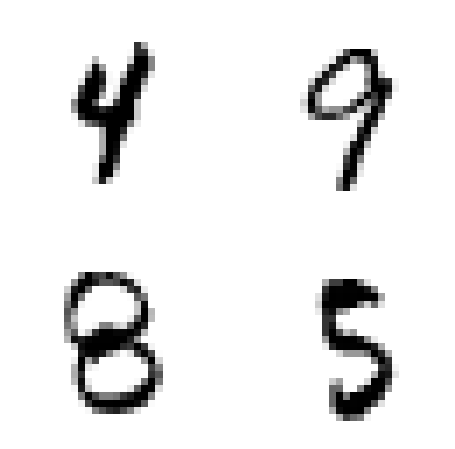

In [11]:
import matplotlib.pyplot as plt

def show_digits(pixel_vals):

    some_digit_image = (
        pixel_vals
        .values
        .reshape(28,28)
        .astype('float32')
    )
    plt.imshow(some_digit_image, cmap = "binary")
    plt.axis("off")

fours = train_features[train_target == 4]
nines = train_features[train_target == 9]
eights = train_features[train_target == 8]
fives = train_features[train_target == 5]

plt.figure(figsize=(8,8))
plt.subplot(221); show_digits(fours.iloc[0])
plt.subplot(222); show_digits(nines.iloc[0])
plt.subplot(223); show_digits(eights.iloc[1])
plt.subplot(224); show_digits(fives.iloc[1])

Accuracy: 0.95725


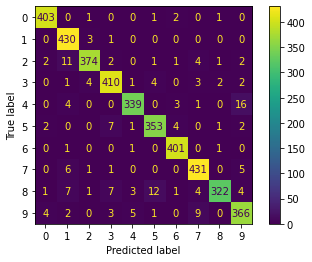

In [23]:
import requests
import json
import numpy as np

bucket_name = 'lh-lambda-buckets-pod2-april20'
key =  'validation/test_features.joblib'

data = {
    'bucket':bucket_name,
    'key':key,
}

headers = {
    'Content-type': "application/json"
}

# Main code for post HTTP request
url = "https://qjiim4z1db.execute-api.eu-west-2.amazonaws.com/dev/predict"
response = requests.request("POST", url, headers=headers, json=data)
lambda_predictions = np.array(response.json())
show_cm(test_target, lambda_predictions, range(10))

In [1]:
!jupyter nbconvert deploying_lambda.ipynb --to html --template classic

[NbConvertApp] Converting notebook deploying_lambda.ipynb to html
[NbConvertApp] Writing 412187 bytes to deploying_lambda.html
